<a href="https://colab.research.google.com/github/nikashahabi/Cryptic-Unstable-Transcripts-Identification-with-Deep-Learning/blob/main/%C2%ABPart6_TrainingClassifierWithNewData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.utils import resample
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from keras import backend as K
from sklearn.utils import class_weight

In [ ]:
# df = pd.read_pickle("/content/drive/MyDrive/Bioinformatics/shuffled_df_new_with_sequences_vectors_and_labels.pkl")
df = pd.read_pickle("/content/drive/MyDrive/Bioinformatics/snRNA + snoRNA + ncRNA + other ncRNAs from paper + overlapping cuts + nonoverlappingcuts (sequence, label and vector).csv")

In [ ]:
df

,sequence,label,vectors
0,TATTTTCGAGAATAATTCTTTTTTTCAGGTTCATGGCACATTTTTC...,1,"[-0.19782084226608276, 0.03133830055594444, 0...."
1,AAGAAATGTACACTATGTTTCTAAACACTGGCAGTGATCAGATTGA...,1,"[-0.19980959594249725, 0.1672704517841339, -0...."
2,GTAAATGACGAGAAAAAAGCTGTGCACCAGTCTGAACATGGATGCC...,0,"[-0.0547851026058197, 0.0653567984700203, 0.64..."
3,CCTGCCGTTTTTGTTTTGTAAGGGTGAGGAAAAACTGGGGACGATG...,0,"[-0.2736167013645172, -0.08636614680290222, 0...."
4,AAGAAATTTAATAATTTTGAAAATGGATTTTTTTGTTTTGGCAAGA...,0,"[-0.12111446261405945, 0.06727982312440872, 0...."
...,...,...,...
1308,GGGCACATGGCGCAGTTGGTAGCGCGCTTCCCTTGCAAGGAAGAGG...,0,"[0.03973401337862015, 0.1697627753019333, 0.92..."
1309,CGTCAAGATATTTGAAAGTTAATAGACAGTTAACAATAATAACAAC...,1,None
1310,ACATTTAGGCCTAGCTATATATGCTACTATGTATCATTCAGTGAAA...,0,None
1311,TTGTCCCAAAAAAGATCACTTTCGTTGTGTTTATTGTCATTGGTAT...,1,"[0.19825679063796997, -0.08999010920524597, 0...."


In [ ]:
df['vectors'] = df['vectors'].apply(np.squeeze)
df = df[df['vectors'].notna()]
df['vectors'].apply(lambda x:x.shape == (768,)).all()
X = np.stack(df['vectors'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_final, X_validation_final, y_train_final, y_validation_final = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
kf = KFold(n_splits = 5)                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
def create_new_model():
  return keras.models.Sequential([
        keras.layers.Dense(50,input_dim=768, activation="relu"),
      keras.layers.Dense(25, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

In [ ]:
def plotLearningCurve(history, optimizer):
    'plotting the learning curve'
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(label="keras_learning_curves_plot_with_" + optimizer + "_optimizer")
    plt.show()
    # plt.close("all")

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
EPOCHS = 50
OPTIMIZER = "adam"
METRICS=["accuracy",f1]
LOSS="binary_crossentropy"
create_new_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                38450     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 39,751
Trainable params: 39,751
Non-trainable params: 0
_________________________________________________________________


## Cross Validation

In [ ]:

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
fold_var = 1
best_result = -1*np.inf

for train_index, val_index in kf.split(np.zeros(len(y_train)),y_train):
  print(f"fold:{fold_var}")
  training_data = X_train[train_index]
  training_data_y = y_train.iloc[train_index]
  # Calculate the weights for each class so that we can balance the data
  classes=np.unique(training_data_y)
  weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=classes,
                                            y=training_data_y)
  class_weights = {i: weights[i] for i in classes}
  validation_data = X_train[val_index]
  validation_data_y = y_train.iloc[val_index]
  # CREATE NEW MODEL
  model = create_new_model()
  # COMPILE NEW MODEL
  model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
	# FIT THE MODEL
  history = model.fit(training_data,training_data_y,epochs=EPOCHS,validation_data=(validation_data,validation_data_y),verbose=0, class_weight=class_weights)
	
  results = model.evaluate(validation_data,validation_data_y)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  #saving best model yet
  if results['f1'] > best_result:
    print(f"best performance increased. saving model: {best_result} -> {results['f1']}")
    best_result = results['f1']
    model.save('./best_model.h5')

  tf.keras.backend.clear_session()
	
  fold_var += 1
	

fold:1
5/5 [==============================] - 0s 3ms/step - loss: 0.5187 - accuracy: 0.8028 - f1: 0.8539
best performance increased. saving model: -inf -> 0.8539144396781921
fold:2
5/5 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.7943 - f1: 0.8411
fold:3
5/5 [==============================] - 0s 3ms/step - loss: 0.4530 - accuracy: 0.8085 - f1: 0.8407
fold:4
5/5 [==============================] - 0s 4ms/step - loss: 0.4837 - accuracy: 0.8369 - f1: 0.8881
best performance increased. saving model: 0.8539144396781921 -> 0.8881222605705261
fold:5
5/5 [==============================] - 0s 3ms/step - loss: 0.4897 - accuracy: 0.7801 - f1: 0.8316


## Training Final Model

In [ ]:
EPOCHS = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
classes=np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                          classes=classes,
                                          y=y_train)
class_weights = {i: weights[i] for i in classes}
# CREATE NEW MODEL
model = create_new_model()
# COMPILE NEW MODEL
model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
# FIT THE MODEL
history = model.fit(X_train_final,y_train_final,epochs=EPOCHS,validation_data=(X_validation_final,y_validation_final),verbose=1, class_weight=class_weights, callbacks=[callback])
model.save('./final_model.h5')

tf.keras.backend.clear_session()


Epoch 1/100
20/20 [==============================] - 2s 26ms/step - loss: 0.6209 - accuracy: 0.6472 - f1: 0.7146 - val_loss: 0.5725 - val_accuracy: 0.7324 - val_f1: 0.8243
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5619 - accuracy: 0.7339 - f1: 0.7835 - val_loss: 0.5142 - val_accuracy: 0.7606 - val_f1: 0.8672
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5259 - accuracy: 0.7795 - f1: 0.8365 - val_loss: 0.5419 - val_accuracy: 0.7183 - val_f1: 0.8122
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.4985 - accuracy: 0.7795 - f1: 0.8174 - val_loss: 0.4961 - val_accuracy: 0.7746 - val_f1: 0.8692
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.4952 - accuracy: 0.7528 - f1: 0.7869 - val_loss: 0.5992 - val_accuracy: 0.7042 - val_f1: 0.7609
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.4750 - accuracy: 0.7827 - f1: 0.8222 - val_loss: 0.5225 - val_accurac

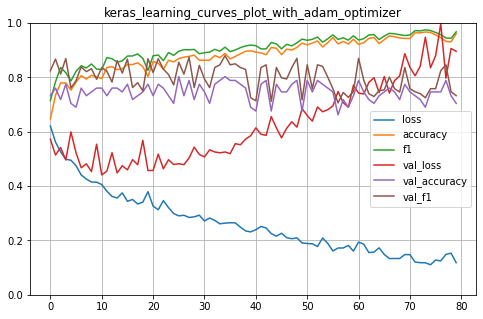

In [ ]:
import matplotlib.pyplot as plt
# plot learning curve
plotLearningCurve(history, OPTIMIZER)

In [ ]:
model = keras.models.load_model('./final_model.h5',custom_objects={"f1":f1})

In [ ]:
# make prediction on test set
y_prediction = model.predict(X_test)
y_prediction_bool = (y_prediction > 0.5).astype(int)

In [ ]:
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    # K.get_session().run(tf.local_variables_initializer())
    return auc

In [ ]:

print("classification report with "+ OPTIMIZER +  "\n")
from sklearn.metrics import classification_report
# y_prediction_bool = y_prediction_bool.reshape((28,1))
print(classification_report(y_test, y_prediction_bool))

classification report with adam

              precision    recall  f1-score   support

           0       0.60      0.70      0.65        57
           1       0.85      0.78      0.81       120

    accuracy                           0.75       177
   macro avg       0.72      0.74      0.73       177
weighted avg       0.77      0.75      0.76       177



In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_prediction_bool)
print('ROC AUC=%.3f' % (auc))

ROC AUC=0.738


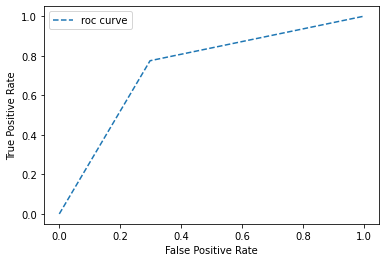

In [ ]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, y_prediction_bool)
# plot the roc curve for the model
from matplotlib import pyplot
pyplot.plot(fpr, tpr, linestyle='--', label='roc curve')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_prediction_bool))

0.7383771929824561


In [ ]:
len(X_test)

177

In [ ]:
len(X_train_final)

635

In [ ]:
len(X_validation_final)

71

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_prediction_bool, y_test)

In [ ]:
confusion_matrix

array([[40, 27],
       [17, 93]])